In [85]:
import timeit
import pytz
import glob
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16,6)

Here I compare several databases for suitability of storing financial timeseries. I'm examining this from a point of view typical of the workflow of a quantitative researcher. Specifically, I'm interested in reading loads of data from the database, and then analysing it with Pandas.

I use historical forex ticks from Pepperstone, which used to be freely available to download. Their dataset is about 30GB of zipped CSV files, organized by month.

https://www.pepperstone.com/en/client-resources/historical-tick-data

In this post, I evaluate Arctic, kdb+(32bit), Cassandra. InfluxDB looks to have made significant progress in the last few years, and the Apache Parquet/Arrow looks *extremely* interesting -- and Wes McKinney (of Pandas fame) is heavily involved in development there. Given what [I've read](http://wesmckinney.com/blog/python-parquet-multithreading/), Parquet/Arrow/Pandas2.0 should be a complete slam dunk for this use-case when available, however I will leave that InfluxDB for later, in the interest of time and brevity.



# The Data
I'm looking at three years worth of tick level data on the AUD/USD pair. This is about 133 million rows, and about 3GB once stored in a dataframe. I'm deliberately keeping it under 4GB so we can fairly evaluate kdb+, as the free version (32bit) is limited to about 4GB of memory. I did this all on a laptop with 16GB of RAM. Despite the dataframe only taking up around 3GB, Python often ended up asking for up to 20+GB of memory. 

In [11]:
# Load the raw data
all_files = glob.glob("./raw_data/*.csv")
raw = pd.concat((pd.read_csv(f, header=None, names=["symbol","date","bid","ask"]).drop("symbol", 1) for f in all_files))

raw["date"] = pd.to_datetime(raw["date"])
raw = raw.set_index("date").tz_localize(pytz.utc)

# Save some information about how much data we have.
num_rows = len(raw)
num_bytes = raw.memory_usage().sum()

print("Raw data has %s million rows and takes up %s megabytes." % (num_rows/1000000, num_bytes/1024/1024))

Raw data has 133.047743 million rows and takes up 3045.22116852 megabytes.


# Data Ingestion

### Arctic
[Arctic](http://github.com/manahl/arctic) is a "High performance datastore for time series and tick data", built by the rather large hedge fund Man AHL and built on MongoDB. Generally speaking, I have avoided MongoDB in the past because, well, [it doesn't do what it says on the tin](https://aphyr.com/posts/322-jepsen-mongodb-stale-reads). This seems to have been [fixed](https://jepsen.io/analyses/mongodb-3-4-0-rc3), and in fairness, it's not too important if you lose a handful out of a few billion rows of timeseries data.

Great video RE design: https://vimeo.com/album/3660528/video/145842301
It's attractive how focused Arctic seems to be on working with Pandas


Arctic expects to be able to read port '27017', so spin up that container with:
`sudo docker-compose up -d mongo`


CHUNKSTORE OR TICKSTORE?
According to [this issue](https://github.com/manahl/arctic/issues/197), the TickStore is best for continuously reading/writing data (ticks), and the ChunkStore is best for writing large blocks at once. Arctic's authors use Kafka to queue and batch-write ~3 hours worth of ticks, I believe as a ChunkStore. I'll be working with the ChunkStore, though I briefly tested the TickStore and it is definitely not appropriate. Many firms use the same approach with KDB, i.e. aggregating ticks in memory, and writing down to disk every few hours.

In [90]:
from arctic import CHUNK_STORE
from arctic import Arctic

# Initialize Arctic
arctic_db = Arctic('localhost')
arctic_db.initialize_library("fx_chunkstore", lib_type=CHUNK_STORE)
arctic_chunk_lib = arctic_db["fx_chunkstore"]

In [39]:
# Benchmark functions
def insert_to_arctic(df):
    arctic_chunk_lib.delete("AUDUSD")
    arctic_chunk_lib.write("AUDUSD", df)
    

def read_from_arctic():
    return arctic_chunk_lib.read("AUDUSD")

I'd like to see how performance scales with the number of rows, so lets make a graph.

In [91]:
num_rows = []
write_speeds = []
read_speeds = []

# Plot performance up to 10m rows in 500k increments.
df = None
for i in range(500000, 5000000, 500000):
    df = raw[:i]
    num_rows.append(i)
    write_speeds.append( (timeit.timeit('insert_to_arctic(df)', 'from __main__ import insert_to_arctic, df', number=5)/5) )
    read_speeds.append( (timeit.timeit('read_from_arctic()', 'from __main__ import read_from_arctic, df', number=5)/5) )


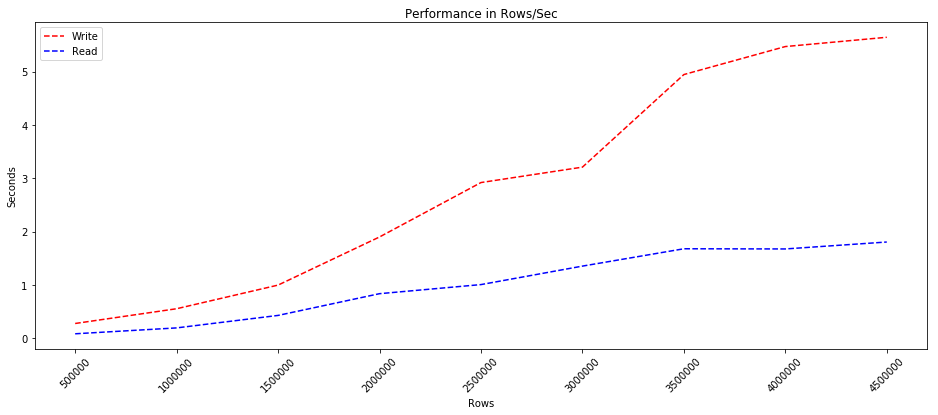

In [92]:
plt.plot(num_rows, write_speeds, 'r--', label="Write")
plt.plot(num_rows, read_speeds, 'b--', label="Read")
plt.legend()
plt.title("Performance in Rows/Sec")
plt.xlabel("Rows")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.show()